# Code for Medium blog "Deep Learning to Jump"

### by Maxime Bergeron, Ivan Sergienko

Best deep learning practices require, at a minimum, having a test set and learning in batches. 
The code implemented in function `learn()` does not adhere to best practices. It is only intended to illustrate the points made in our blog.

In [1]:
import torch
import torch.nn.functional as F
import copy
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [2]:
torch.manual_seed(31415)    # Random seed fixed for reproducibility

## Generate and plot jump data

In [3]:
n = 1000    # number of training samples
t = torch.FloatTensor(n, 1).uniform_(0, 1)
y = torch.ones_like(t)
drop_size, location = 0.3, 0.4
y[t > location] = 1 - drop_size

Text(0.5, 0, 'time')

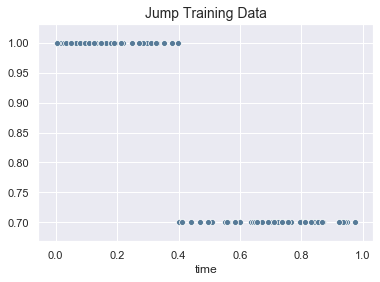

In [4]:
# Plot first 100 points
sns.set(style="darkgrid", palette="muted", color_codes=True)
sns.set_palette(sns.color_palette("Set1", n_colors=8, desat=.5))

t_plot = t[:100].squeeze(dim=1)
y_plot = y[:100].squeeze(dim=1)

ax = sns.scatterplot(t_plot, y_plot, color='C1')
plt.title("Jump Training Data", fontsize=14)
ax.set_xlabel("time")

## Neural network with one unit

In [5]:
# Torch does not have a step activation function, so we define it
def heaviside(x):
    # 0.5 * (torch.sign(x) + 1) works too, but we want to be true to the mathematical
    #     definition of Heaviside function, without the point in the middle at 0
    
    y = torch.ones_like(x)
    y[x < 0] = 0
    return y

In [6]:
class OneNode(torch.nn.Module):
    """
    a simple 1-dimensional neural net with a single hidden layer
    """
    def __init__(self, act_func):
        super(OneNode, self).__init__()

        self.act_func = act_func
        
        # input and output linear layers
        self.linears = torch.nn.ModuleList([torch.nn.Linear(1, 1) for _ in range(2)])
        
    def forward(self, x):
        x = self.linears[0](x)
        x = self.linears[1](self.act_func(x))
        return x

In [7]:
def plot(model, x, y, epoch, ax, title=""):
    """
    Plot part of learning data and current model predictions
    """
    x_data = x[:100].squeeze(dim=1)
    y_data = y[:100].squeeze(dim=1)
    
    x_pred = torch.linspace(torch.min(x), torch.max(x),100).unsqueeze(dim=1)
    y_pred = model(x_pred).squeeze(dim=1).detach().numpy()
    x_pred = x_pred.squeeze(dim=1)

    sns.scatterplot(x_data, y_data, color='C1', ax=ax)
    ax.set_title(title, fontsize=14)
    ax.text(0.6, 1.0, f"Epoch {epoch}", fontsize=14)
#     ax.set_title(f"Epoch {epoch}", fontsize=14)
    ax.set_xlabel("time")
    sns.lineplot(x_pred, y_pred, color='C1', ax=ax)

def learn(model, x, y, lr=0.1, title=""):
    """
    Use model to learn the function f(x)=y.
    lr is Adam learning rate.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_func = torch.nn.MSELoss()

    n_epochs = 20000
    loss_array = torch.zeros(n_epochs)
    best_model, min_loss = model, 1

    sns.set(style="darkgrid", palette="muted", color_codes=True)
    sns.set_palette(sns.color_palette("Set1", n_colors=8, desat=.5))
    plt.suptitle("Learning progress", weight='bold')
    f, axes = plt.subplots(2, 2, figsize=(12, 10))
    plot_epochs = [n_epochs // 4, n_epochs // 2, 3 * n_epochs // 4, n_epochs]
    plot_epochs = [100, 1000, 3000, n_epochs]
    plot_counter = 0

    for e in range(n_epochs):
        prediction = model(x)
        loss = loss_func(prediction, y)

        optimizer.zero_grad()  # clear gradients for next cycle
        loss.backward()        # backpropagation, compute gradients
        optimizer.step()       # step in the right direction
        loss_array[e] = loss

        if loss.item() < min_loss:  # keep track of best model
            best_model = copy.deepcopy(model)
            min_loss = loss.item()

        if (e + 1) in plot_epochs:
            plot(best_model, x, y, e+1, axes[plot_counter // 2, plot_counter % 2], title=title)
            plot_counter += 1
    
    plt.show()
    return loss_array, best_model

In [8]:
def plot_loss(loss_array, title=""):
    ax = sns.lineplot(x=torch.arange(len(loss_array)), y=loss_array.detach().numpy())
    ax.set(yscale="log")
    ax.set_title(title)
    ax.set_xlabel("Epoch")

## Sigmoid Unit

In [9]:
# initialise vanilla 1-dim neural net with single hidden layer
model = OneNode(act_func=torch.sigmoid)

<Figure size 432x288 with 0 Axes>

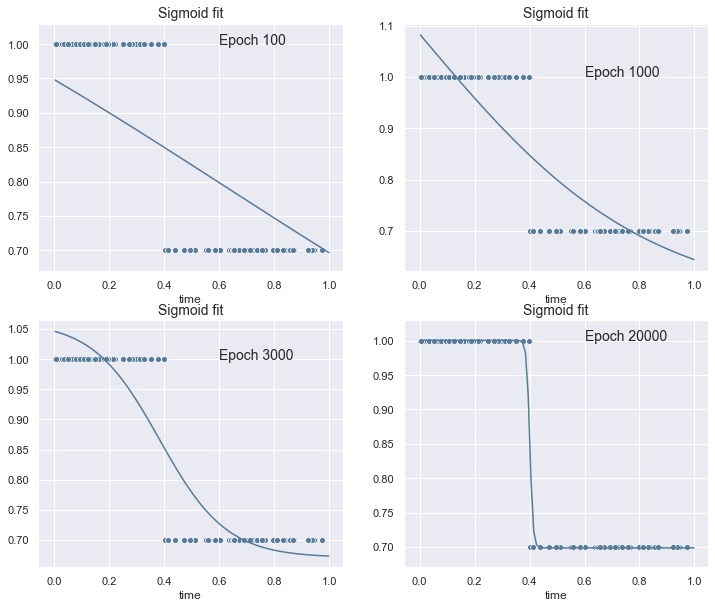

In [10]:
# train the model on the step function
loss_array, model = learn(model=model, x=t, y=y, title="Sigmoid fit")

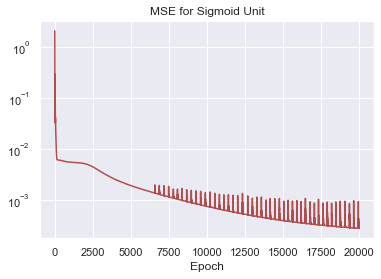

In [11]:
# visualize loss over traing time
plot_loss(loss_array, "MSE for Sigmoid Unit")

## Heaviside Unit

<Figure size 432x288 with 0 Axes>

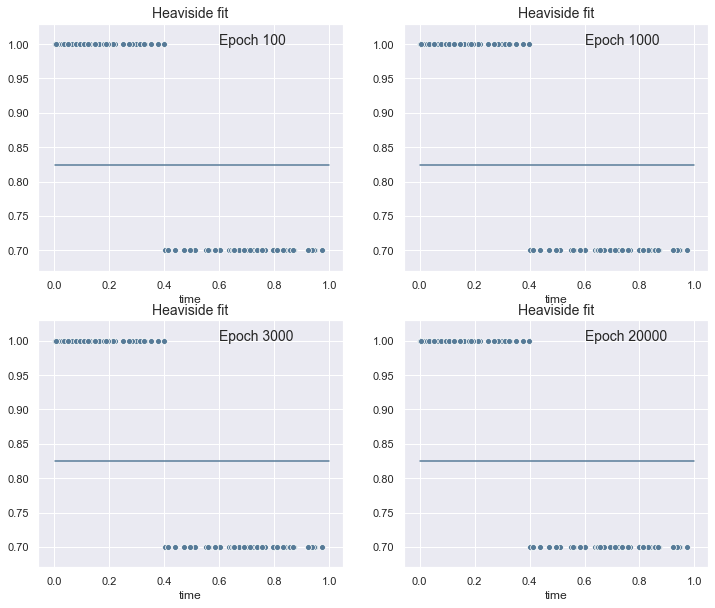

In [12]:
# initialise vanilla 1-dim neural net with single hidden layer
model = OneNode(act_func=heaviside)
# train the model on the step function
loss_array, model = learn(model=model, x=t, y=y, title="Heaviside fit")

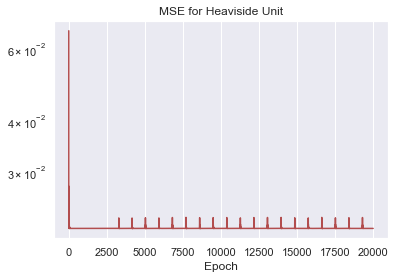

In [13]:
# visualize loss over training time
plot_loss(loss_array, "MSE for Heaviside Unit")

### Visualize Heaviside loss function

In [14]:
wH = -0.3
bH = 1.0
N = 20
def MSE(b):
    tmp = y[:N] - wH * heaviside(t[:N] + b) - bH
    return torch.sum(tmp * tmp) / N

Text(0.5, 0, '$b_{in}$')

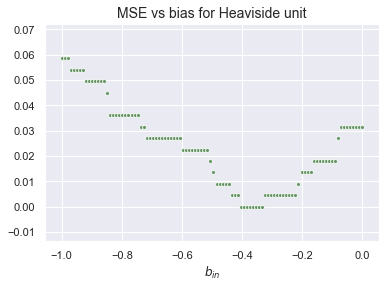

In [15]:
b_in = np.linspace(-1, 0, 100)
mse = np.array([MSE(b) for b in b_in])

ax = sns.scatterplot(b_in, mse, color='C2', s=15)
plt.title("MSE vs bias for Heaviside unit", fontsize=14)
ax.set_xlabel(r'$b_{in}$')

## Jump Unit

In [16]:
class JumpUnit(torch.nn.Module):
    """
    a simple 1-dimensional network with a single hidden layer and Heaviside activation
    """
    def __init__(self):
        super(JumpUnit, self).__init__()

        self.act_func = torch.sigmoid
        
        # On linear node for input and output
        self.linears = torch.nn.ModuleList([torch.nn.Linear(1, 1) for _ in range(2)])
        self.linears.append(torch.nn.Linear(1, 1, bias=False))
        
    def forward(self, x):
        x = self.linears[0](x)
        h = self.linears[1](heaviside(x))
        s = self.linears[2](self.act_func(x))
        
        return h + s

<Figure size 432x288 with 0 Axes>

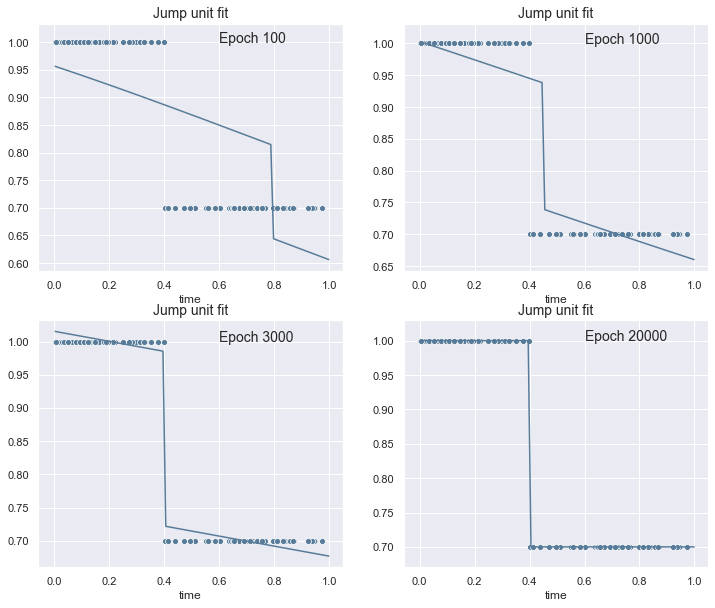

In [17]:
# initialize jump unit net
model = JumpUnit()
# train the model on the step function
loss_array, model = learn(model=model, x=t, y=y, lr=0.1, title="Jump unit fit")

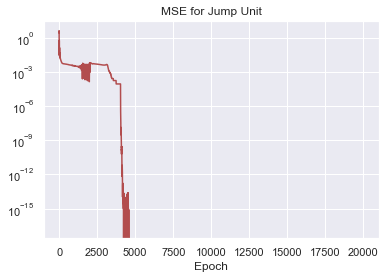

In [18]:
# visualize loss over training time
plot_loss(loss_array, "MSE for Jump Unit")

### Visualize Jump Unit loss function

In [19]:
wH = -0.3
bH = 1.0
w_in = 1.0
N = 20
def MSE_jump_unit(wS, b):
    tmp = y[:N] - (wS * torch.sigmoid(w_in * t[:N] + b) + wH * heaviside(w_in * t[:N] + b) + bH)
    return torch.sum(tmp * tmp) / N

In [20]:
b_in = np.linspace(-1, 0, 50)
w_s = np.linspace(-0.5, 0.5, 50)
bs, ws = np.meshgrid(b_in, w_s)

bs_1 = np.reshape(bs, -1)
ws_1 = np.reshape(ws, -1)

mse_ju = np.array([MSE_jump_unit(w, b) for w, b in zip(ws_1, bs_1)])

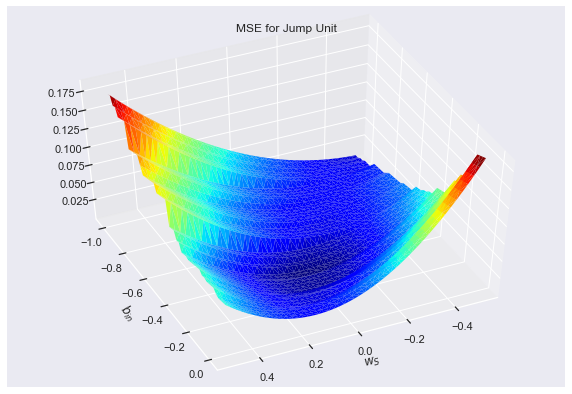

In [21]:
fig = plt.figure(figsize=[10,7])
ax = fig.gca(projection='3d')
ax.plot_trisurf(ws_1, bs_1, mse_ju, cmap=plt.cm.jet, linewidth=0.01)
ax.view_init(azim=65, elev=50)
plt.title("MSE for Jump Unit")
plt.ylabel(r"$b_{in}$")
plt.xlabel(r"$w_S$")
plt.show()